# Importe

In [52]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
import scipy as sp

import matplotlib.pyplot as plt

from uncertainties import ufloat

plt.rc('text', usetex=True)    # Dieser Befehl überschreibt die Grafiken in LaTeX Formation
plt.style.use('classic')

# Functions

Hier sollten eigentlich die Funktionen stehen

In [44]:
def chi_sq(y, fx, u_y, p=2):    # für 2 Fitparameter
    """
    Variables
      n [int]:                length of the
      y [numpy array]:        y values for the y axis
      fx [numpy array]:       y values from the regression
      u_y[int, numpy array]:  Unsicherheit/uncertainty from y
      p [int]:                number of parameters of the regression
    Return:
      chi square
    """
    n = len(y)
    factor = 1 / (n - p)
    return factor * np.sum((y - fx)**2 / u_y**2)

# Daten laden für den Zylinder

In [ ]:
Z = pd.read_csv('Daten_Zylinder.txt', sep='\t', index_col='Index')

# winkel in Grad
gam = np.array(Z['gamma'])

# gemessene Zeiten
T1_Z = np.array(Z['T1']) / 10   # durch 10 Teilen, weil wir uns für eine Schwingung interessieren
T2_Z = np.array(Z['T2']) / 10
print(Z)

# winkel in Radianten
gam = np.radians(gam[1:])     # Gamma in rad (Radiant) umwandeln, weil np.sin() in rad rechnet
# print(gam)

# print(T1_Z)

       gamma    T1    T2
Index                   
H        NaN  4.90  4.68
P1       0.0  5.81  5.76
P2      15.0  6.24  6.28
P3      30.0  6.50  6.46
P4      45.0  7.11  7.06
P5      60.0  7.66  7.63
P6      75.0  8.04  8.02
P7      90.0  8.13  8.11


## Geometrie und Masse des Zylinder

In [3]:
m_Z_err = ufloat(1.352, 0.1 / 1000)                 # Masse in kg
print(m_Z_err)
h_err = ufloat(0.1010, 0.05 / (10 * 100))             # HÖhe, Fehler: err=0.05mm, in meter
print(h_err)
d_err = ufloat(0.041, 0.05 / (10 * 100))              # Durchmesser,  meter
r_err = d_err / 2                                  # Radius,meter
print(r_err)

1.35200+/-0.00010
0.10100+/-0.00005
0.020500+/-0.000025


# Benötigte Gleichungen

$$ J_{Z}=\frac{D\cdot T^{2}}{4\pi^{2}}\\ J_{tisch}=5.8\cdot 10^{-4} \text{kg} \text{m}^{2}\\ D= 0.1036$$

In [4]:
J_tisch = 5.8e-4
J_ti_err = ufloat(J_tisch, 0.00002)

D = 0.1036
D_err = ufloat(D, 0.0025)


# ohne Fehler
def J_Z(T):
    k = (D / (4 * np.pi**2)) * T**2
    return k


# Mit Fehler
def J_err(T):
    k = (D_err / (4 * np.pi**2)) * T**2
    return k

# T mitteln

In [5]:
# T1 und T2 in einem Array
T_Z = np.zeros((8, 2))
for i in range(8):
    for j in range(2):
        if j == 0:
            T_Z[i][0] = T1_Z[i]
        else:
            T_Z[i][1] = T2_Z[i]

# Mittel von T1 und T2
T_Z_mean = np.zeros(8)
for i in range(8):
    T_Z_mean[i] = T_Z[i].mean()
print('Mittel', T_Z_mean)
print()

# Standardabweichung von T_Z
T_Z_std = np.zeros(8)
for i in range(8):
    T_Z_std[i] = np.std(T_Z[i], ddof=1)
print('Standardabweichung', T_Z_std)
print()

# Standardfehler von T_Z
m_std_err = T_Z_std / np.sqrt(len(T_Z))
print('Standardfehler: ', m_std_err)

Mittel [0.479  0.5785 0.626  0.648  0.7085 0.7645 0.803  0.812 ]

Standardabweichung [0.01555635 0.00353553 0.00282843 0.00282843 0.00353553 0.00212132
 0.00141421 0.00141421]

Standardfehler:  [0.0055  0.00125 0.001   0.001   0.00125 0.00075 0.0005  0.0005 ]


# Berechnung von $J_{gama}$ in Beziehung zu $T^{2}$

$$ J_{gamma}=J_{Z}-J_{Halterung}-J_{Tisch} $$

## Berechnung von $J_{gamma}$ mit Fehlern

In [6]:
T_err = np.array([ufloat(0.479, 0.0055), ufloat(0.5785, 0.00125),
    ufloat(0.626, 0.001), ufloat(0.648, 0.001), ufloat(0.7085, 0.00125),
    ufloat(0.7645, 0.00075), ufloat(0.803, 0.0005), ufloat(0.812, 0.0005)])



J_Z_er = J_err(T_err)
# print(J_er)

# Halterung mit Fehler
J_halt_er = J_Z_er[0]
print(J_halt_er)

# J_gamma mit Fehler
J_gamma_er = J_Z_er[1:] - J_halt_er
print(J_gamma_er)

# Fehler von J_Gamma
yerr = np.array([2.5e-5, 2.7e-5, 2.7e-5, 3e-5, 3e-5, 4e-5, 4e-5])

0.000602+/-0.000020
[0.000276123567293052+/-1.581103060456412e-05
 0.00042626495744202723+/-1.7543919579095513e-05
 0.000499816557941828+/-1.8660805552402558e-05
 0.0007151815906847201+/-2.2597309095650822e-05
 0.0009316481392086089+/-2.6564563885278215e-05
 0.0010900164548451998+/-2.979093846764901e-05
 0.0011281594730150513+/-3.060831359302446e-05]


## Vorbereitung zur Berechnung von $J_{gamma}$ ohne Fehler

In [ ]:
# yerr=np.array([0.0156,0.0035,0.0028,0.0028,0.0035,0.0021,0.0014,0.0014])
# print(T_Z_mean)

# J_Z ohne Fehler
J_Z = J_Z(T_Z_mean)

# print('J_Z',J_Z)

# J_Z Auschließlich der Halterung
k = J_Z[0]
# print('T_Halterung',k)


# J_halterung ohne Fehler
J_halterung = k
print('J_halterung', J_halterung)

# J_Z vom Zylinder
J_Z = J_Z[1:]
J_Z

J_halterung 0.0006021033527285139


array([0.00087823, 0.00102837, 0.00110192, 0.00131728, 0.00153375,
       0.00169212, 0.00173026])

## Berechnung von $J_{gamma}$ ohne Fehler

In [8]:

print('J_Z:', J_Z)
print('J_halterung: ', J_halterung)
print('J_tisch:', J_tisch)
J_gam = J_Z - J_halterung - J_tisch
J_gam

J_Z: [0.00087823 0.00102837 0.00110192 0.00131728 0.00153375 0.00169212
 0.00173026]
J_halterung:  0.0006021033527285139
J_tisch: 0.00058


array([-3.03876433e-04, -1.53735043e-04, -8.01834421e-05,  1.35181591e-04,
        3.51648139e-04,  5.10016455e-04,  5.48159473e-04])

# Regression

## Definition der Regressionsgeraden

In [9]:
def J_g(a, b, sin_gam):
    k = a * sin_gam + b
    return k
# jz=b, jy=b+a
# print(len(yerr))

## Variante 1: Regressionsparameter a und b berechnen, mit scipy

In [10]:
# yerr=yerr[1:]
sin_gam = np.sin(gam)**2
# print(len(sin_gam))
# print(len(yerr))
pop, cov = curve_fit(J_g, sin_gam, J_gam, sigma=yerr)
a1, b1 = pop
da1, db1 = np.sqrt(np.diag(cov))
# a1=round(a1,0)
# b1=round(b1,5)
# da1=round(da1,0)
# db1=round(db1,5)

print(a1)
print(b1)
print(da1)
print(db1)
a1_err = ufloat(a1, da1)
b1_err = ufloat(b1, db1)
print()
print('a: ', a1_err, ', Fehler: ', round(da1 / a1 * 100, 2), '%')
print('b: ', b1_err, ', Fehler: ', round(db1 / b1 * 100, 2), '%')

-0.0002688460817114376
0.0008234010779038166
2.0464736557605478e-05
3.8894481861650066e-05

a:  -0.000269+/-0.000020 , Fehler:  -7.61 %
b:  0.00082+/-0.00004 , Fehler:  4.72 %


## Variante 2: mit statsmodels

In [18]:
x = sin_gam


# Lineare Regression

y = J_gam
x_zunahme = sm.add_constant(x)
results = sm.WLS(y, x_zunahme, sigma=yerr).fit()
# print('''
# Lineare Regression
# ''')
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     633.3
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.85e-06
Time:                        08:59:38   Log-Likelihood:                 63.555
No. Observations:                   7   AIC:                            -123.1
Df Residuals:                       5   BIC:                            -123.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003   2.05e-05    -13.042      0.0

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [12]:
print(sin_gam)

[0.        0.0669873 0.25      0.5       0.75      0.9330127 1.       ]


# Plot

In [22]:
b = results.params[0]
a = results.params[1]

In [ ]:
J_gam

array([-3.03876433e-04, -1.53735043e-04, -8.01834421e-05,  1.35181591e-04,
        3.51648139e-04,  5.10016455e-04,  5.48159473e-04])

In [39]:
xreg = np.linspace(-0.1, 1.3, 100)

In [40]:
J_reg = a * xreg + b

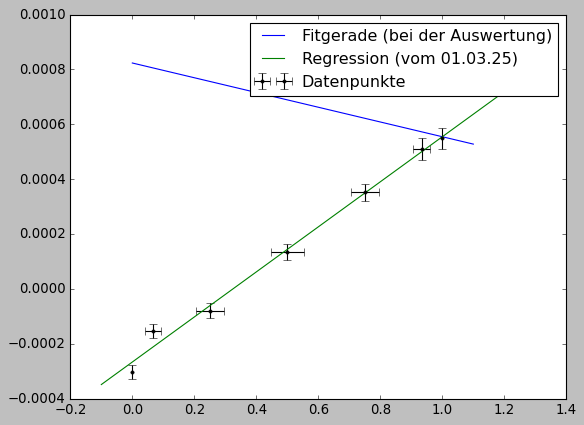

In [ ]:
xxx = np.linspace(0, 1.1, 500)
sigg = np.sin(xxx)**2
# plt.axis('equal')

xerr = np.radians(3 * np.ones(7))
xerr *= 2 * np.sin(gam) * np.cos(gam)
y_test = J_g(a, b, sigg)
plt.errorbar(sin_gam, J_gam, xerr=xerr, yerr=yerr, fmt='k.', label='Datenpunkte', capsize=4)
plt.plot(xxx, J_g(a1, b1, xxx), label='Fitgerade (bei der Auswertung)')
plt.plot(xreg, J_reg, label='Regression (vom 01.03.25)')
plt.legend()
# plt.savefig('Regression_Zylinder.png',dpi=500)
plt.show()

In [48]:
# chi^2 mit Funktion aus damaliger Auswertung
chi_sq_gam = round(chi_sq(J_gam, J_g(a1, b1, sin_gam), yerr, p=2), 2)
print(chi_sq_gam)

935.8


In [49]:
# vom 1.3.25
chi_sq_gam2 = round(chi_sq(J_gam, J_g(a, b, sin_gam), yerr, p=2), 2)
print(chi_sq_gam2)

1.5


# Aufgabe 5

## Theoretische Werte

In [50]:
# Für gamma =0°
J_Z_Err = 0.5 * m_Z_err * r_err**2
print(J_Z_Err)

# für gamma = 90°
J_y_Err = 0.5 * m_Z_err * (0.5 * r_err**2 + 1 / 6 * h_err**2)
print(J_y_Err)

0.0002841+/-0.0000007
0.0012914+/-0.0000012


## Regressionswerte

In [51]:
J_Z = b1
print(J_Z)

J_y = b1 + a1
print(J_y)

# Fehler
fehler_J_Z = J_Z / J_Z_Err * 100
print(fehler_J_Z, '%')

fehler_J_y = J_y / J_y_Err * 100
print('(', fehler_J_y, ')', '%')

0.0008234010779038166
0.0005545549961923791
289.8+/-0.7 %
( 42.94+/-0.04 ) %
